Dataset: http://nlp.uit.edu.vn/datasets/

Classify 7 states of emotions in terms of enjoyment, disgust, sadness, anger, surprise, fear and others from text using PhoBert, a state of the art pre-trained BERT for the Vietnamese language

From UIT with ♥

### About data:

Emotion recognition is a higher approach or special case of sentiment analysis. In this task, the result is not produced in terms of either polarity: positive or negative or in the form of rating (from 1 to 5) but of a more detailed level of sentiment analysis in which the result are depicted in more expressions like sadness, enjoyment, anger, disgust, fear and surprise. Emotion recognition plays a critical role in measuring brand value of a product by recognizing specific emotions of customers’ comments. In this study, we have achieved two targets. First and foremost, we built a standard Vietnamese Social Media Emotion Corpus (UIT-VSMEC) with about 6,927 human-annotated sentences with six emotion labels, contributing to emotion recognition research in Vietnamese which is a low-resource language in Natural Language Processing (NLP). Secondly, we assessed and measured machine learning and deep neural network models on our UIT-VSMEC. As a result, Convolutional Neural Network (CNN) model achieved the highest performance with 57.61% of F1-score.

### Set Up

In [ ]:
# For read excel format form pandas
!pip install openpyxl
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.2 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, AutoConfig, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

### Load Data

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown 10U3ShbGdakYKIpwvoLRzJEOP_zRRy3zT

Downloading...
From: https://drive.google.com/uc?id=10U3ShbGdakYKIpwvoLRzJEOP_zRRy3zT
To: /content/UIT-VSMEC-20230520T124243Z-001.zip
100% 319k/319k [00:00<00:00, 139MB/s]


In [ ]:
!unzip /content/UIT-VSMEC-20230520T124243Z-001.zip

Archive:  /content/UIT-VSMEC-20230520T124243Z-001.zip
  inflating: UIT-VSMEC/valid_nor_811.xlsx  
  inflating: UIT-VSMEC/test_nor_811.xlsx  
  inflating: UIT-VSMEC/train_nor_811.xlsx  


In [ ]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

train_df = get_data('/content/UIT-VSMEC/train_nor_811.xlsx')
valid_df = get_data('/content/UIT-VSMEC/valid_nor_811.xlsx')
test_df = get_data('/content/UIT-VSMEC/test_nor_811.xlsx')

# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_, "kfold"] = fold

In [ ]:
train_df.sample(5)

,Emotion,Sentence,kfold
3706,Enjoyment,dễ thương ghê ! làm mình nhớ các cậu bạn cùng ...,2.0
3913,Enjoyment,đáng yêuc vãi anh ơi,3.0
234,Surprise,bất ngờ chưa =))),0.0
658,Surprise,cha con y chang nhau 😂 1 khuôn đúc ra,0.0
821,Enjoyment,lợi ích của việc giữ vững quan điểm 😄,0.0


In [ ]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   6234 non-null   object 
 1   Sentence  6234 non-null   object 
 2   kfold     6234 non-null   float64
dtypes: float64(1), object(2)
memory usage: 146.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None)

**=> No Missing Values**

<Axes: xlabel='Emotion', ylabel='count'>

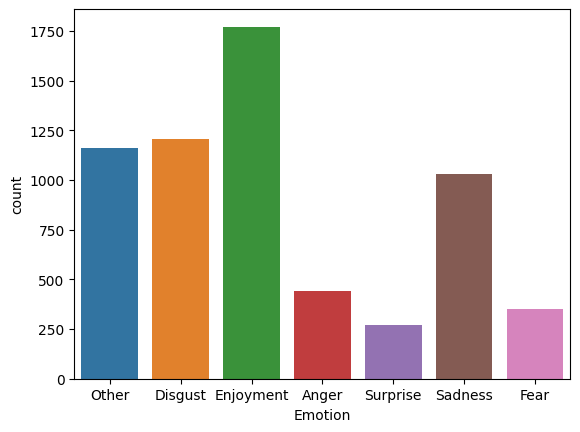

In [ ]:
sns.countplot(x='Emotion', data=train_df)

**=> Imbalanced labels! But We still want to classify 7 classes**

### DataLoader

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Enjoyment':
            return 0
        elif text=='Disgust':
            return 1
        elif text=='Sadness':
            return 2
        elif text=='Anger':
            return 3
        elif text=='Surprise':
            return 4
        elif text=='Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])

        return text, label

**BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.**

Text(0.5, 9.444444444444438, 'Token Count')

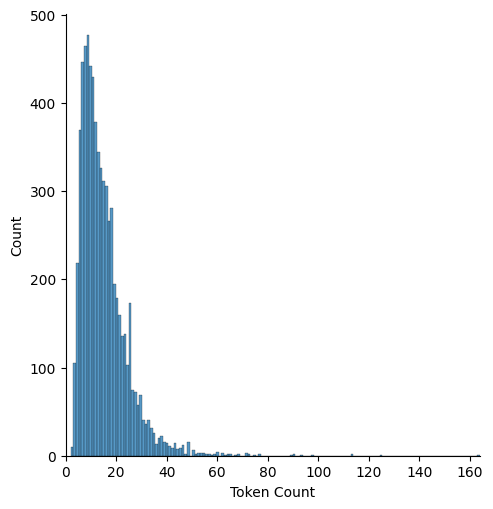

In [ ]:
# Distribution of length of Sentence
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

**=> Choose a maximum of length of 50 is safe.**

In [ ]:
config = AutoConfig.from_pretrained("vinai/phobert-base")

### Model

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base", config= config)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )
        # Normal
        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
#CLS Embeddings
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base", config= config)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        #Last Hidden State Output
        #CLS Embeddings
        #narrow the tensor to [batch, 1, hidden_state]

        narrowed_last_hidden_state = last_hidden_state[:, -1, :].unsqueeze(1)

        x = self.drop(narrowed_last_hidden_state)
        x = x.view(-1, self.bert.config.hidden_size)
        x = self.fc(x)


        return x

In [ ]:
#Max
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base", config= config)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )


        #Max pooling
        # expand attention mask to match last_hidden_state shape
        expanded_attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.shape)

        # apply attention mask to last_hidden_state
        masked_last_hidden_state = last_hidden_state * expanded_attention_mask

        # replace all masked values with a very large negative value
        masked_last_hidden_state[expanded_attention_mask == 0] = -1e9

        # take max embeddings along max_len axis
        max_embeddings, _ = torch.max(masked_last_hidden_state, dim=1)

        x = self.drop(max_embeddings)
        x = self.fc(x)
        return x

In [ ]:
#Mean
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base", config= config)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        #Mean
        # expand attention mask to match last_hidden_state shape
        expanded_attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.shape)

        # apply attention mask to last_hidden_state
        masked_last_hidden_state = last_hidden_state * expanded_attention_mask

        # sum embeddings along max_len axis
        summed_embeddings = torch.sum(masked_last_hidden_state, dim=1)

        # sum attention mask along max_len axis
        summed_mask = torch.sum(expanded_attention_mask, dim=1)

        # take average
        averaged_embeddings = summed_embeddings / summed_mask

        x = self.drop(averaged_embeddings)
        x = self.fc(x)
        return x

In [ ]:
# Mean-max pooling
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base", config= config)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
            )

        # Mean pooling
        # expand attention mask to match last_hidden_state shape
        expanded_attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.shape)

        # apply attention mask to last_hidden_state
        masked_last_hidden_state = last_hidden_state * expanded_attention_mask

        # sum embeddings along max_len axis
        summed_embeddings = torch.sum(masked_last_hidden_state, dim=1)

        # sum attention mask along max_len axis
        summed_mask = torch.sum(expanded_attention_mask, dim=1)

        # take average
        averaged_embeddings = summed_embeddings / summed_mask

        # Max pooling
        # replace all masked values with a very large negative value
        masked_last_hidden_state[expanded_attention_mask == 0] = -1e9

        # take max embeddings along max_len axis
        max_embeddings, _ = torch.max(masked_last_hidden_state, dim=1)

        # Concatenate mean and max embeddings
        pooled_embeddings = torch.cat((averaged_embeddings, max_embeddings), dim=1)

        print(pooled_embeddings.shape)
        x = self.drop(pooled_embeddings)
        x = self.fc(x)
        print(x.shape)
        return x

In [ ]:
# #Conv1D

# class SentimentClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(SentimentClassifier, self).__init__()
#         self.bert = AutoModel.from_pretrained("vinai/phobert-base", config=config)
#         self.conv1 = nn.Conv1d(self.bert.config.hidden_size, 256, kernel_size=2, padding=1)
#         self.conv2 = nn.Conv1d(256, 1, kernel_size=2, padding=1)
#         self.drop = nn.Dropout(p=0.3)
#         self.fc = nn.Linear(256, n_classes)
#         nn.init.normal_(self.fc.weight, std=0.02)
#         nn.init.normal_(self.fc.bias, 0)

#     def forward(self, input_ids, attention_mask):
#         last_hidden_state, output = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             return_dict=False # Dropout will errors if without this
#         )

#         # Transpose to get shape (batch_size, hidden_size, sequence_length)
#         transposed_hidden_state = last_hidden_state.transpose(1, 2)

#         # Apply the first convolutional layer followed by ReLU activation and max pooling
#         x = self.conv1(transposed_hidden_state)
#         x = nn.functional.relu(x)
#         x = nn.functional.max_pool1d(x, kernel_size=2)

#         # Apply the second convolutional layer followed by ReLU activation and global max pooling
#         x = self.conv2(x)
#         x = nn.functional.relu(x)
#         x = nn.functional.max_pool1d(x, kernel_size=x.shape[2])

#         # Flatten the output tensor and apply dropout
#         x = x.view(-1, 256)
#         x = self.drop(x)

#         # Pass through the fully connected layer
#         x = self.fc(x)
#         return x

In [ ]:
#LSTM
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base", config=config)
        self.drop = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(self.bert.config.hidden_size, self.bert.config.hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        # Apply dropout to last hidden state
        last_hidden_state = self.drop(last_hidden_state)

        # Pass the last hidden state through the LSTM layer
        lstm_output, _ = self.lstm(last_hidden_state)

        # Concatenate the forward and backward states of the LSTM
        concatenated_states = torch.cat((lstm_output[:, -1, :self.bert.config.hidden_size], lstm_output[:, 0, self.bert.config.hidden_size:]), dim=1)

        # Pass the concatenated states through the fully connected layer
        x = self.fc(concatenated_states)
        return x

### Train & Eval Function

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


### Training with K-Fold

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [ ]:
print(skf.n_splits)
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

5
-----------Fold: 1 ------------------
Epoch 1/6
------------------------------
Train Accuracy: 0.34690194505714855 Loss: 1.7228041119300401
Valid Accuracy: 0.5004009623095429 Loss: 1.3678207366894453
Epoch 2/6
------------------------------
Train Accuracy: 0.5474233005815119 Loss: 1.26214184707556
Valid Accuracy: 0.5854049719326383 Loss: 1.1646951200106206
Epoch 3/6
------------------------------
Train Accuracy: 0.643473029877682 Loss: 1.0087128408635273
Valid Accuracy: 0.6078588612670409 Loss: 1.1269969091965601
Epoch 4/6
------------------------------
Train Accuracy: 0.7250852215760978 Loss: 0.8132942834725747
Valid Accuracy: 0.6214915797914996 Loss: 1.1296989558598933
Epoch 5/6
------------------------------
Train Accuracy: 0.7677962703027872 Loss: 0.6769967447393216
Valid Accuracy: 0.6118684843624699 Loss: 1.2082138466529357
Epoch 6/6
------------------------------
Train Accuracy: 0.8004812512532584 Loss: 0.5973137102256982
Valid Accuracy: 0.6142742582197274 Loss: 1.2160852047113

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.67      0.64      0.66       193
           1       0.59      0.61      0.60       132
           2       0.65      0.67      0.66       116
           3       0.46      0.30      0.36        40
           4       0.64      0.49      0.55        37
           5       0.67      0.72      0.69        46
           6       0.51      0.59      0.55       129

    accuracy                           0.61       693
   macro avg       0.60      0.57      0.58       693
weighted avg       0.61      0.61      0.61       693



### Heatmap between Predict and Ground Truth

<AxesSubplot:>

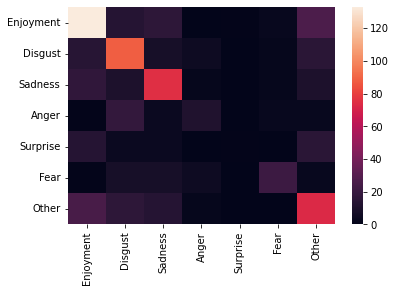

In [ ]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

=> Label Fear is the most unrelated to others -> Highest F1-Score

### Visualize Wrong Predicted Label

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Other) --vs-- Real label: (Surprise)
--------------------------------------------------
bố không thích nộp đấy mày thích ý kiến không
Predicted: (Other) --vs-- Real label: (Anger)
--------------------------------------------------
có ai như tao vô đọc bình luận 🤣 tao cười tao xĩu
Predicted: (Anger) --vs-- Real label: (Sadness)
--------------------------------------------------
sống 17 năm chưa crush ai bao giờ
Predicted: (Enjoyment) --vs-- Real label: (Other)
--------------------------------------------------
ổng quay thiệt mà sao chửi ổng thế . không quay sao máy bạn xem được đó :))
Predicted: (Disgust) --vs-- Real label: (Fear)
--------------------------------------------------
nghe ngọt thế :((
Predicted: (Sadness) --vs-- Real label: (Fear)
--------------------------------------------------
kinh khủng thật :((
Predicted: (Anger) --vs-- Real label: (Other)
------------------------

### Inference

In [ ]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [ ]:
infer('Cảm ơn bạn đã chạy thử model của mình. Chúc một ngày tốt lành nha!', tokenizer)

Text: Cảm ơn bạn đã chạy thử model của mình. Chúc một ngày tốt lành nha!
Sentiment: Enjoyment


### <center> Thanks for reading 🥰🥰🥰 </center>

### References:

* https://github.com/VinAIResearch/PhoBERT

* https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

* http://nlp.uit.edu.vn/datasets/

* https://www.kaggle.com/code/shoheiazuma/tweet-sentiment-roberta-pytorch/notebook#Model

* https://skimai.com/fine-tuning-bert-for-sentiment-analysis/